# Photoionization

## TO DO

- 1 orders of magnitude difference between brute force numerical integration and seperation of radial and angular part. <br>
> - Test 1 : integration of 3 harmonic spherics: CG expression and numercial integration give the same result when increasing grid point --> OK
> - Python tplquad and trap give same results --> OK
> - cgc python function gives same results as in cgc table --> OK
> - Check if angular part must also multiply the imaginary part fo the radial integrant (if so, the discrpency is recovered).
- Answer free questions
- sum over ml is wrong ! 

## Introduction

In this second module, you will calculate the K-edge photoionization cross section within the single particle approximation and the sudden approximation for three noble gas elements: Neon, Argon and Krypton. Further details on the theory behind this exercise can be found at: J.Phys.B: At.Mol.Opt.Phys. 42 (2009) 023001.

Important: in the following we use the mathematical convention (used by Python) for the spherical coordinates: $\theta$ is the azimuthal angle ($2\pi>\theta>0$) and $\phi$ is the polar angle ($\pi>\phi>0$). It is common to see the opposite convention. The conversion from spherical to cartesian coordinates is therefore given by:

$$x=rsin(\phi)cos(\theta)$$
$$y=rsin(\phi)sin(\theta)$$
$$z=rcos(\phi)$$

Import relevant libraries:

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import integrate, special

The following function is needed to solve the exercises

In [3]:
from sympy.physics.quantum.cg import CG

def cgc(j1,m1,j2,m2,j3,m3):
    
    '''
    uses the sympy module to calculate the Clebsch Gordan coefficients
    <j1m1j2m2|j3m3>
    '''

    cg = CG(j1,m1,j2,m2,j3,m3).doit().evalf()
    
    return cg

# numerical integration
def triple_trap(nr,nt,nph,intD,rf,*arg):
    
    # integration limits
    r1 = 0.
    t1 = 0.
    tf = 2*(np.pi) 
    p1 = 0.
    pf = np.pi
    
    # integration steps
    dr = (rf-r1)/nr
    dt = (tf-t1)/nt
    dp = (pf-p1)/nph  
    
    ans = 0.
    for i in range(nr-1):
        for j in range(nt-1):
            for k in range(nph-1):
                ri = r1 + dr/2 + i*dr
                tj = t1 + dt/2 + j*dt
                pk = p1 + dp/2 + k*dp
                ans += dr*dt*dp*intD(pk,tj,ri,*arg)
    
    return ans

The following python function returns the hydrogen-like $\Psi_{nlm}$ for given value of $n,l,m, \theta,\phi$, $r$ and $Z_{eff}$. The function is very similar to the one you've already written in module I.


In [4]:
def Psi(n,l,m,r,phi,thet,Z):
    '''
    n: principal quantum number
    l: azimuthal quantum number
    m: magnetic quantum number
    r, phi and thet: spherical coordinates
    Z: nuclear charge
    
    return the total wave function Psi, the radial part R and the angular part Y
    '''

    # angular part -> spherical harmonics
    Y = special.sph_harm(m,l,thet,phi)

    # radial part containing the associated Laguerre polynomials
    R = np.sqrt((math.factorial(n-l-1)*(2*Z/n)**3)/(2*n*math.factorial(n+l)))
    R *= (2*r*Z/n)**l
    R *= np.exp(-Z*r/n)
    x = 2*r*Z/n
    R *= special.assoc_laguerre(x,n-l-1,2*l+1)

    psi = Y*R

    return psi, R, Y


The following functions are useful to calculate the wavefunction of the 1s orbital of Neon ($Z_{eff}$=9.642), Argon ($Z_{eff}$=17.508) and Krypton ($Z_{eff}$=35.232). Take as a reference the functions written in module I.

In [5]:
def Ne_1s(r,phi,theta):
    Zeff = 9.642
    return Psi(1,0,0,r,phi,theta,Zeff)[0]

def Ar_1s(r,phi,theta):
    Zeff = 17.508
    return Psi(1,0,0,r,phi,theta,Zeff)[0]

def Kr_1s(r,phi,theta):
    Zeff = 35.232
    return Psi(1,0,0,r,phi,theta,Zeff)[0]

### Photoionization: theory
The transition dipole moment of an ionization process involves a bound and a continuum state as initial and final state, respectively. If one describes the ejected electron as a free particle (hence neglecting the interaction between the ejected electron and the $N-1$ core), the final state can be expressed as a product between a bound state and a continuum state $\Psi_{f}=\Psi^{N-1}\Phi_e$, where $\Phi_e$ describes the ejected electron. The transition moment becomes $<\Psi^{N-1}\Phi_e|\hat{r}|\Psi^{N}>$. <br> 

In an independent electron picture, the integral simplifies to $<\Phi_e|\hat{r}|\Phi_{i}>$ where $\Phi_i$ is a one-particle eigenstate of a single body hamiltonian, i.e. the Fock hamiltonian. It represents the initial state (i.e. the molecular orbital in the single particle picture) of the electron before being promoted into the continuum during the ionisation process. Here we also assume that the final $\Psi^{N-1}$ state is not perturbed by the loss of the electron. This approximation is usually referred to as the sudden approximation. <br>

The free electron wave function is expressed as a plane wave:

$$\Phi_e(\vec{k},\vec{r}) = \frac{1}{(2\pi)^{\frac{3}{2}}}e^{i\vec{k}\vec{r}} $$

where the prefactor is a normalization factor. Expressing the plane wave as an expansion over spherical harmonics, one obtains the following expression: 

$$\Phi_e(\vec{k},\vec{r}) = \frac{2}{\sqrt{2\pi}} \sum_{l=0}^{\infty}\sum_{m=-l}^{l} i^lj_l(kr)Y_{l}^{m}(\vec{k})Y_{l}^{m*}(\vec{r})$$ 

where $\vec{k}$ is the wave vector of the ejected electron in spherical coordinates $\vec{k}=(k,\theta_k,\phi_k)$ and $\vec{r}$ is the position vector $\vec{r}=(r,\theta,\phi)$. The radial part $j_l(kr)$ is given by the spherical Bessel function (which can be retrieved from the 'scipy.special' package by means of 'special.spherical\_jn(l,kr)'). The limit of the sum over the $l$ values is usually taken as $l_{max}$ that is large enough to reach convergence.

**1) Write down a function to calculate the free electron's wave function $\Phi_e(k,r,\theta_k,\phi_k,\theta,\phi) =\frac{2}{\sqrt{2\pi}} \sum_{l=0}^{lmax}\sum_{m=-l}^{l} i^lj_l(kr)Y_{l}^{m}(\theta_k,\phi_k)Y_{l}^{m*}(\theta,\phi)$ for a given $k, l_{max},r, \theta$, $\phi$, $\theta_k$ and $\phi_{k}$.** 

In [76]:
def phi_e(k,l_max,r,th,ph,thk,phk):
        
    Y  = special.sph_harm
    j_l = special.spherical_jn

    i = complex(0,1)    #imaginary unit
    prefactor = (2/(math.sqrt(2*np.pi)))
    
    ans = 0  
    for l in range(l_max+1):
        rad = (i**l)*j_l(l,k*r)
        if l == 0:
            ans += rad*Y(0,l,thk,phk)*np.conj(Y(0,l,th,ph))
        else:
            for m in range(-l,l+1,1):
                ans += rad*Y(m,l,thk,phk)*np.conj(Y(m,l,th,ph))

    return ans*prefactor

**2) Plot the radial probability density (with radius between 0 a.u. and 50 a.u.) of $\phi_e$ with $l_{max}=10$. Choose various values of $\theta$, $\phi$, $\theta_k$, $\phi_k$ and $k$.** 

You might want to start with $\theta=\phi=\theta_k=\phi_k=0$ or $\theta=\pi/2$, $\phi=\pi/5$, $\theta_k=\pi/7$, $\phi_k=\pi/3$ for example.

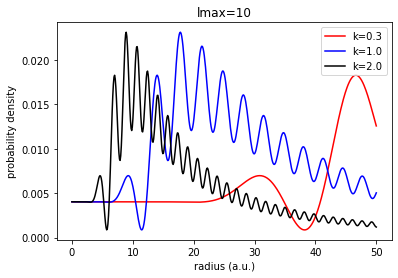

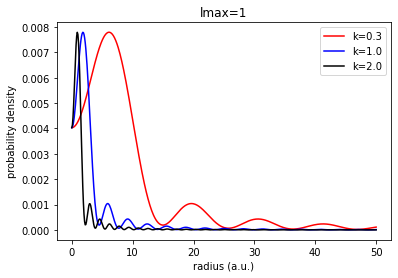

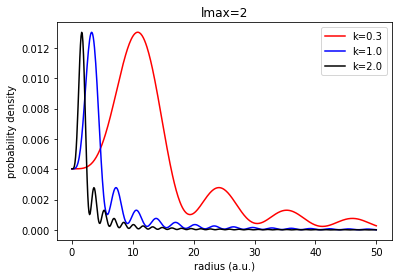

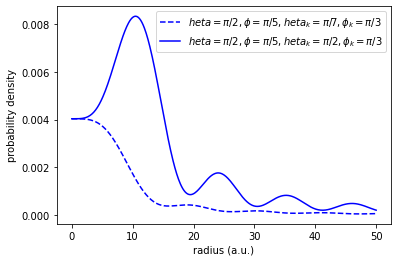

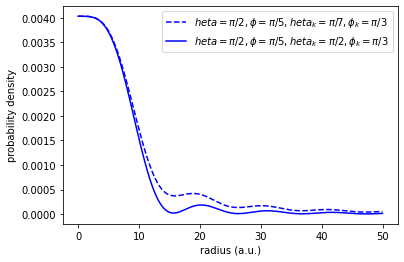

In [77]:
r_list = np.linspace(0,50,500)

# compare different k along the z axes
lmax = 10
plt.xlabel('radius (a.u.)')
plt.ylabel('probability density')
plt.plot(r_list,abs(phi_e(0.3,lmax,r_list,0,0,0,0))**2,'r',label='k=0.3')
plt.plot(r_list,abs(phi_e(1.0,lmax,r_list,0,0,0,0))**2,'b',label='k=1.0')
plt.plot(r_list,abs(phi_e(2.0,lmax,r_list,0,0,0,0))**2,'k',label='k=2.0')
plt.legend()
plt.title('lmax=10')
plt.show()

lmax = 1
plt.xlabel('radius (a.u.)')
plt.ylabel('probability density')
plt.plot(r_list,abs(phi_e(0.3,lmax,r_list,0,0,0,0))**2,'r',label='k=0.3')
plt.plot(r_list,abs(phi_e(1.0,lmax,r_list,0,0,0,0))**2,'b',label='k=1.0')
plt.plot(r_list,abs(phi_e(2.0,lmax,r_list,0,0,0,0))**2,'k',label='k=2.0')
plt.legend()
plt.title('lmax=1')
plt.show()

lmax = 2
plt.xlabel('radius (a.u.)')
plt.ylabel('probability density')
plt.plot(r_list,abs(phi_e(0.3,lmax,r_list,0,0,0,0))**2,'r',label='k=0.3')
plt.plot(r_list,abs(phi_e(1.0,lmax,r_list,0,0,0,0))**2,'b',label='k=1.0')
plt.plot(r_list,abs(phi_e(2.0,lmax,r_list,0,0,0,0))**2,'k',label='k=2.0')
plt.legend()
plt.title('lmax=2')
plt.show()

# compare different angles
plt.xlabel('radius (a.u.)')
plt.ylabel('probability density')
plt.plot(r_list,abs(phi_e(0.3,lmax,r_list,np.pi/2,np.pi/5,np.pi/7,np.pi/3))**2,'b--',label='$ \theta=\pi/2, \phi=\pi/5, \theta_k=\pi/7, \phi_k=\pi/3$')
plt.plot(r_list,abs(phi_e(0.3,lmax,r_list,np.pi/2,np.pi/5,np.pi/2,np.pi/3))**2,'b',label='$ \theta=\pi/2, \phi=\pi/5, \theta_k=\pi/2, \phi_k=\pi/3$')
plt.legend()
plt.show()

# compare different angles (phi and phi_k)
plt.xlabel('radius (a.u.)')
plt.ylabel('probability density')
plt.plot(r_list,abs(phi_e(0.3,lmax,r_list,np.pi/2,np.pi/5,np.pi/7,np.pi/3))**2,'b--',label='$ \theta=\pi/2, \phi=\pi/5, \theta_k=\pi/7, \phi_k=\pi/3$')
plt.plot(r_list,abs(phi_e(0.3,lmax,r_list,np.pi/2,np.pi/2,np.pi/7,np.pi/3))**2,'b',label='$ \theta=\pi/2, \phi=\pi/5, \theta_k=\pi/2, \phi_k=\pi/3$')
plt.legend()
plt.show()

The partial differential photoionisation cross section associated with the population of the final state $\phi_e$ is given by:

$$\frac{\partial \sigma_{i}^{k}}{\partial \Omega}=4\pi^2\, \alpha \, \omega_{in} \, m_e \, \delta(E_{\Phi_e}-E_{\Phi_i}-\omega_{in}) \,|<\Phi_e(\vec{r},\vec{k})|\vec{r} |\Phi_i(\vec{r})>|^2$$

where $\omega_{in}$ is the energy of the incoming photon, $\alpha$ is the fine structure constant (corresponding to 1/c in atomic units), $\Omega=sin(\phi_k)\partial \theta_k \partial \phi_k$ and $m_e$ is the electron mass (=1 in a.u.). The conservation of energy enforced by the delta function imposes that $E_{\Phi_e}-E_{\Phi_i}=\omega_{in}$ is respected. $E_{\Phi_i}$ is the binding energy of the electron whose opposite can, in the context of Koopman's theorem, be considered equal to the ionization potential IP of the orbital $i$. In the context of our model, the binding energy is equal to -[$(\frac{Z_{eff}}{n})^2$*Ry] where Ry represents the Rydberg constant (i.e. 13.6 eV). Dividing by the atomic unit of energy (i.e. 27.211 eV) the value of the binding energy in a.u. can be retrieved. On the other hand, $E_{\Phi_e}$ is the kinetic energy of the free electron which, in atomic units, is equal to $E_{\Phi_e}=\frac{1}{2}k^2$. All considered, we can therefore rewrite the conservation of energy relation as $\frac{1}{2}k^2+IP = \omega_{in}$.

The ability to resolve $\theta_k$ and $\phi_k$ allows to perform photoelectron angular distribution spectroscopy. Here, we are only interested in the total photoionization cross section, hence we integrate over $\Omega$. Replacing $\Phi_e$ using the plane wave expansion above leads to the following expression:

$$ \sigma_i^k = 4\pi^2\, \alpha \, \omega_{in} \, m_e  \int_{\Omega} |\sum_{l=0}^{\infty}\sum_{m=-l}^{l} Y_{l}^{m}(\theta_k,\phi_k)<\frac{2}{\sqrt{2\pi}}i^lj_l(kr)Y_{l}^{m*}(\vec{r})\,|\,\vec{r}\,|\,\Phi_i> |^2 d \Omega  $$

Since only $Y_{l}^{m}(\theta_k,\phi_k)$ depends on $\Omega$ and since we use orthonormalized harmonic spherics with $\int Y_{l}^{m}(\theta_k,\phi_k) Y_{l}^{m*}(\theta_k,\phi_k) d \Omega$ = 1, we can integrate $Y_{l}^{m}(\theta_k,\phi_k)$ out of the expression. The integrated cross section becomes: 

$$\sigma_i^k=4\pi^2 \, \alpha \, \omega_{in} \, m_e |\sum_{l=0}^{\infty}\sum_{m=-l}^{l}<\frac{2}{\sqrt{2\pi}}i^lj_{l}(kr)Y_{l}^{m*}(\vec{r})|\vec{r}|\Phi_i>|^2$$

We define 

$$\Phi_e'(k,r,\theta,\phi) =\frac{2}{\sqrt{2\pi}} \sum_{l=0}^{lmax}\sum_{m=-l}^{l} i^lj_l(kr)Y_{l}^{m*}(\theta,\phi)$$

which coresponds to $\Phi_e$ without the term depending on $\theta_k$ and $\phi_k$.
We can then rewrite the integrated cross section as:

$$\sigma_i^k=4\pi^2 \, \alpha \, \omega_{in} \, m_e |<\Phi_e'(\vec{r},\theta,\phi)|\vec{r}|\Phi_i>|^2$$

In the following we will only consider a $z$ polarized photon, hence $\vec{r}=r_{z}=rcos(\phi)$ 


**3) Write down a function that returns the real and imaginary part of the integrand needed to calculate the z component of the dipole transition moment $<\Phi_e'|rcos(\phi)|\Phi_{1s}>$. $\Phi_{1s}$ is the wave function associated to the $1s$ orbital of Neon, Argon and Krypton.** 

*Hint 1: use the $\Phi_e$ function written above but without the $Y_{l}^{m}(\theta_k,\phi_k)$ factor to write down a function for $\Phi_e'$.* 

*Hint 2: refer to the transition moment section of module I.*

In [79]:
# phi_e' --> phi_e without the Ylm(tk,phk) factor

def phi_ep(k,lmax,r,th,ph):
        
    Y  = special.sph_harm
    jl = special.spherical_jn
    
    i = complex(0,1)
    prefactor = (2/(math.sqrt(2*np.pi)))
    
    ans = 0
    for l in range(lmax+1):
        rad = jl(l,k*r)
        if l == 0:
          ans += i*l*rad*Y(0,l,th,ph)
        else:
           for m in range(-l,l+1,1):
               ans += i*l*rad*Y(m,l,th,ph)
    
    return ans*prefactor

# integrand rz  

def int_ionization_Ne_1s(phi,theta,r,*arg):

    k = arg[0]
    real = arg[1]

    ans  = np.conj(phi_ep(k,lmax,r,theta,phi))
    ans *= r*np.cos(phi)
    ans *= Ne_1s(r,phi,theta)
    ans *= (r**2 * np.sin(phi))
    
    if real:
        return ans.real
    else:
        return ans.imag


def int_ionization_Ar_1s(phi,theta,r,*arg):

    k = arg[0]
    real = arg[1]

    ans  = np.conj(phi_ep(k,lmax,r,theta,phi))
    ans *= r*np.cos(phi)
    ans *= Ar_1s(r,phi,theta)
    ans *= (r**2 * np.sin(phi))       
    
    if real:
      return ans.real
    else:
      return ans.imag

def int_ionization_Kr_1s(phi,theta,r,*arg):

    k = arg[0]
    real = arg[1]

    ans  = np.conj(phi_ep(k,lmax,r,theta,phi))
    ans *= r*np.cos(phi)
    ans *= Kr_1s(r,phi,theta)
    ans *= (r**2 * np.sin(phi))       
    
    if real:
      return ans.real
    else:
      return ans.imag


**4) Plot the real part of the integrand (for whichever atom you like) as a function of $r$ (in a range between 0 and 3 a.u. of length) for several values of $k$, $\theta$ and $\phi$. In particular, look at the behavior of the integrand for small and large values of $k$ (e.g. for k<1 and k>1). Use $l_{max}=5$.**

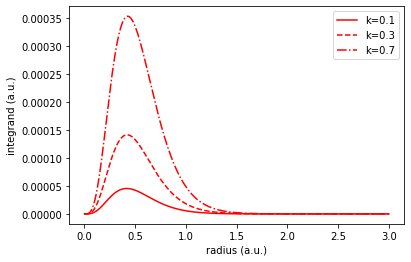

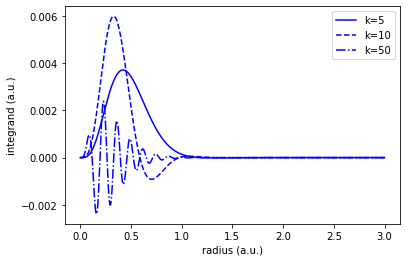

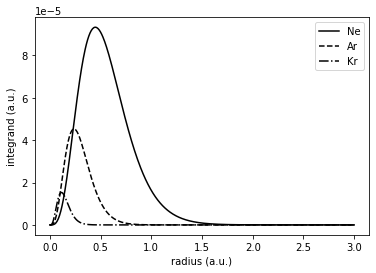

In [80]:
r_list = np.linspace(0,3,500)

lmax = 5
# k < 1 
plt.xlabel('radius (a.u.)')
plt.ylabel('integrand (a.u.)')
plt.plot(r_list,int_ionization_Ne_1s(np.pi/3,np.pi/4,r_list,0.1,True),'r',label='k=0.1')
plt.plot(r_list,int_ionization_Ne_1s(np.pi/3,np.pi/4,r_list,0.3,True),'r--',label='k=0.3')
plt.plot(r_list,int_ionization_Ne_1s(np.pi/3,np.pi/4,r_list,0.7,True),'r-.',label='k=0.7')
plt.legend()
plt.show()

# k > 1
plt.xlabel('radius (a.u.)')
plt.ylabel('integrand (a.u.)')
plt.plot(r_list,int_ionization_Ne_1s(np.pi/3,np.pi/4,r_list,5.0,True),'b',label='k=5')
plt.plot(r_list,int_ionization_Ne_1s(np.pi/3,np.pi/4,r_list,10.0,True),'b--',label='k=10')
plt.plot(r_list,int_ionization_Ne_1s(np.pi/3,np.pi/4,r_list,50.0,True),'b-.',label='k=50')
plt.legend()
plt.show()

# different atoms
plt.xlabel('radius (a.u.)')
plt.ylabel('integrand (a.u.)')
plt.plot(r_list,int_ionization_Ne_1s(np.pi/10,np.pi/7,r_list,1.0,True),'k',label='Ne')
plt.plot(r_list,int_ionization_Ar_1s(np.pi/7,np.pi/5,r_list,1.0,True),'k--',label='Ar')
plt.plot(r_list,int_ionization_Kr_1s(np.pi/3,np.pi/5,r_list,1.0,True),'k-.',label='Kr')
plt.legend()
plt.show()

**5) Plot the real and imaginary part of the integrand as a function of radius (for whichever atom you like) with $k=1$ a.u. and a defined value for $\theta$ and $\phi$ (say $\theta=\pi/3$ and $\phi=\pi/4$), for various values of $l_{max}$.**

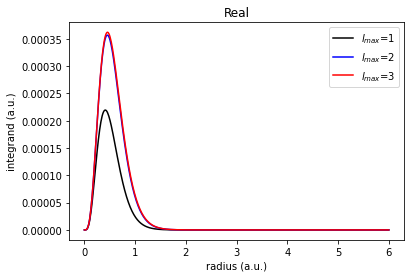

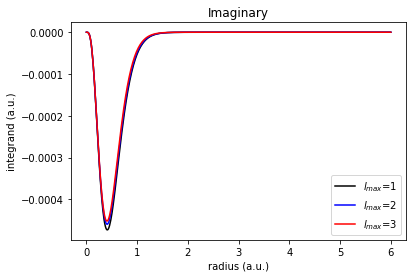

In [ ]:
r_list = np.linspace(0,6,500)

lmax = 1
plt.xlabel('radius (a.u.)')
plt.ylabel('integrand (a.u.)')
lmax = 1
plt.plot(r_list,int_ionization_Ne_1s(np.pi/3,np.pi/4,r_list,1.0,True),'k-',label='$l_{max}$=1')
lmax = 2
plt.plot(r_list,int_ionization_Ne_1s(np.pi/3,np.pi/4,r_list,1.0,True),'b-',label='$l_{max}$=2')
lmax = 3
plt.plot(r_list,int_ionization_Ne_1s(np.pi/3,np.pi/4,r_list,1.0,True),'r-',label='$l_{max}$=3')
plt.title('Real')
plt.legend()
plt.show()

lmax = 1
plt.xlabel('radius (a.u.)')
plt.ylabel('integrand (a.u.)')
lmax = 1
plt.plot(r_list,int_ionization_Ne_1s(np.pi/3,np.pi/4,r_list,1.0,False),'k-',label='$l_{max}$=1')
lmax = 2
plt.plot(r_list,int_ionization_Ne_1s(np.pi/3,np.pi/4,r_list,1.0,False),'b-',label='$l_{max}$=2')
lmax = 3
plt.plot(r_list,int_ionization_Ne_1s(np.pi/3,np.pi/4,r_list,1.0,False),'r-',label='$l_{max}$=3')
plt.title('Imaginary')
plt.legend()
plt.show()

**6) The following block calculates the Neon integrated photoionization cross section for several values of final state' energy (i.e. with $k$ between 0 a.u. and 5 a.u.) and plots $\sigma_i$ as a function of the photon energy.** 

As you can see the $triple\_trap(nr,nth,nph,integrand,rf,*arg)$ function is used to perform the integration according to the trapezoidal rule. We have already prepared a template of the function for you, you have only to substitute the ****** with the definitions and the names of the functions you've previously defined. We want the values of the energy to be expressed in eV and the value of the cross-section to be expressed in MegaBarn (Mb) (1 a.u. = 28 Mb). 
You can try different mesh grids for $r$, $\theta$ and $\phi$. 


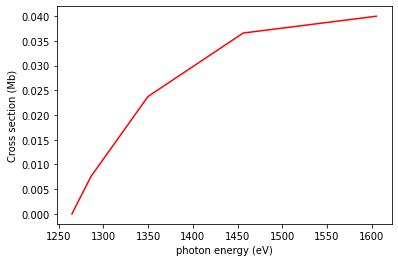

In [ ]:
lmax = 3

# Ionization energy in a.u. of the 1s orbital
IE_Ne_1s = 9.642**2/2     #substitute with the binding energy of Neon

# vector for sigma tot result and etot
Ne1s_sig1 = []    #list of the cross section value for each transition total energy -- creation
Ne_etot_1s = []   #list of transition total energy -- creation

# value for E_k in au
k_vector = np.linspace(0,5,5)

rf = 20
nr = 100
nth = 40
nph = 40

# calculate total cross section for several values of k 
for k in k_vector:
  ek = k**2/2  #energy of the final state
  Ne_etot_1s.append(ek+IE_Ne_1s)  #substitute with the expression to calculate the total energy. Remember the conservation of energy...
  # Integration using trapezoide rule  
  #real = triple_trap(nr,nth,nph,int_ionization_Ne_1s,rf,k,True) #substitute the name of the Ne function you've written in block 3
  #imag = triple_trap(nr,nth,nph,int_ionization_Ne_1s,rf,k,False) #substitute the name of the Ne function you've written in block 3
  # using python integration function
  real = integrate.tplquad(int_ionization_Ne_1s,0,rf,0,2*np.pi,0,np.pi,(k,True))[0]
  imag = integrate.tplquad(int_ionization_Ne_1s,0,rf,0,2*np.pi,0,np.pi,(k,False))[0]
  d2 = abs(complex(real,imag))**2   #module squared of the dipole transition moment
  Ne1s_sig1.append((((4*np.pi**2)*Ne_etot_1s[-1])*d2/137)*2) #substitute the definition of cross section. Remember to account for all the electrons of the shell and the units.

# convert to eV
Ne_etot_1s = np.asarray(Ne_etot_1s)*27.2114
Ne1s_sig1 = np.asarray(Ne1s_sig1)*28

#plot
plt.xlabel('photon energy (eV)') 
plt.ylabel('Cross section (Mb)')
plt.plot(Ne_etot_1s,Ne1s_sig1,'r')
plt.show()


You must have noticed that despite the low value of $l_{max}$ needed to calculate $\Phi_e$, the numerical integration takes quite some time. The computational time will drastically increase if we want to calculate the cross section for larger electron's energy (hence larger energy of the ionizing field). Clearly our "brute" force approach to the calculation of the dipole transition moment is not efficient. 

The problem can be simplified by taking advantage of the properties of the spherical harmonics. The radial and angular part can be seperated in the expression of the transition dipole moment:

$$|<\Phi_e(r)\Phi_e(\theta,\phi)|\vec{r}|\Phi_i(r)\Phi_i(\theta,\phi)>|^2$$

using the partial wave expansion for $\Phi_e$ and accounting for the fact we only want the z component of $\vec{r}$ we have:

$$|\sum_{l=0}^{l_{max}}\sum_{ml=-l}^{+l}<i^lj_l(kr)Y_{l}^{m}(\theta,\phi)|r\,cos(\phi)|R_{\Phi_i}(r)Y_{l'}^{m'}(\theta,\phi)>|^2.$$

where $l'$ and $m'$ are the quantum number associated to the initial orbital $i$ (in our first example $\Phi_i=1s$ and $l_3=m_3=0$). 

Expressing $cos(\phi)$, the angular part of $r_z$, in spherical harmonic basis yields $cos(\phi)=\sqrt{\frac{4\pi}{3}}Y_{10}(\theta,\phi)$. The integral becomes:

$$|\sqrt{\frac{4\pi}{3}}\,\,\sum_{l=0}^{lmax}\sum_{ml=-l}^{+l}<i^lj_l(kr)|r|R_{\Phi_i}(r)><Y_{l}^{m}|Y_{1}^{0}|Y_{l'}^{m'}>|^2$$

the factor involving the 3 spherical harmonics can be simplified using the $\textit{integral over three spherical harmonics}$ relation from angular momentum theory which reads:

$$\sqrt{\frac{(2l+1)(2l_2+1)}{4\pi(2l'+1)}}CG(l\,l_2\,l';m\,m_2\,m')CG(l\,l_2\,l';000) $$

where $CG$ are the Clebsh-Gordan coefficients and $l, m$ are the angular momentum associated to the ejected electron, $l_2, m_2$ are the angular momentum of the photon, and $l', m'$ are the angular momentum of the initial orbital. The function $cgc(l,m,l2,m2,l',m')$ returns the result for a set of angular momentum.
For example:

In [ ]:
print(cgc(1,0,1,0,0,0))
print(cgc(1,0,1,1,1,1))

-0.577350269189626
-0.707106781186548


Function for the 3 harmonic spherics integral

In [84]:
def ang_part(j1,m1,j2,m2,j3,m3):
    
    '''
    Calculates the integral of 3 harmonic spherics
    '''

    cg1 = CG(j1,m1,j2,m2,j3,m3).doit().evalf()
    cg2 = CG(j1,0,j2,0,j3,0).doit().evalf()
    ans = cg1*cg2*np.sqrt((2*j1+1)*(2*j2+1)/(4*np.pi*(2*j3+1)))

    return ans

In our case $l_2=1$, $m_2=0$ (z polarized photon), $l'=0$ and $m'=0$ ($1s$ orbital)

**7) Try to calculate the $CG$ coefficient for different value of $l$ and $ml$. You should recover the selection rules $\Delta l = (l'-l)= \pm 1$ and $\Delta ml = (ml' - ml)= 0$ for a one photon transition, which arise from symmetry consideration.**

In [ ]:
print(cgc(1,0,1,0,0,0))
print(cgc(4,-2,1,0,2,0))
print(cgc(1,0,1,0,2,0))
print(cgc(3,0,1,0,2,0))

-0.577350269189626
0
0.816496580927726
-0.654653670707977


In [ ]:
print(ang_part(1,0,1,0,0,0))

0.282094791773878


This reformulation will considerably reduce the complexity of the integral. Indeed, we only need to perform the integration over the radial part while the angular part is given by the integral over three spherical harmonics expression.

**8) Write down a function to calculate the integrand of the radial part $<i^lj_l(kr)|r|R_{1s}(r)>$ of Ne, Ar and Kr.**

In [82]:
def rad_Ne_1s(r,*arg):
    
    l = arg[0]
    k = arg[1]
    real = arg[2]
    
    jl = special.spherical_jn
    
    ans  = 1
    ans *= np.conj(jl(l,k*r)*(complex(0,1)**l))
    ans *= r**3
    ans *= Psi(1,0,0,r,0,0,9.642)[1]    #Ne-1s orbital
    
    if real:
      return ans.real
    else:
      return ans.imag

def rad_Ar_1s(r,*arg):
    
    l = arg[0]
    k = arg[1]
    real = arg[2]
    
    jl = special.spherical_jn
    
    ans  = 1
    ans *= np.conj(jl(l,k*r)*(complex(0,1)**l))
    ans *= r**3
    ans *= Psi(1,0,0,r,0,0,17.508)[1]    #Ar-1s orbital
    
    if real:
      return ans.real
    else:
      return ans.imag

def rad_Kr_1s(r,*arg):
    
    l = arg[0]
    k = arg[1]
    real = arg[2]
    
    jl = special.spherical_jn
    
    ans  = 1
    ans *= np.conj(jl(l,k*r)*(complex(0,1)**l))
    ans *= r**3
    ans *= Psi(1,0,0,r,0,0,35.232)[1]    #Kr-1s orbital
    
    if real:
      return ans.real
    else:
      return ans.imag

**9) Calculate the integrated cross section of Ne for various photon energies.  Produce a plot similar to the one showed in exercise 6. The upper value for the radial integration (rf=20.0) and the k-vector range are already given.** 

Hint: when structuring your loops consider that the terms in the plane wave expansion will only be non-zero for specific values of $l,m$.



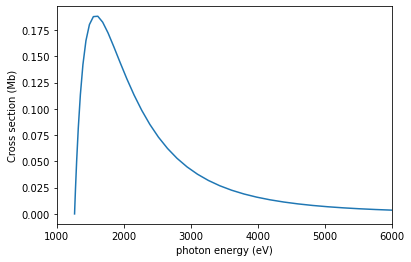

In [86]:
rf = 20.0

k_vector = np.linspace(0,50,100)
IE_Ne_1s = ((9.642**2)/2)# in au
#IE_Kr_1s = (35.232**2)/2
Ne_1s_sig = []
i = np.complex(0,1)
etot_Ne_1s = []

for k in k_vector:
  ek = (k**2/2)# in au
  etot_Ne_1s.append((ek+IE_Ne_1s))  
  sum = 0
  # only need l = 1,0
  for l in (1,0):
      ang = ang_part(l,0,1,0,0,0)*np.sqrt(4*np.pi/3)  
      real = integrate.quad(rad_Ne_1s, 0, rf,(l,k,True))[0]*ang
      imag = integrate.quad(rad_Ne_1s, 0, rf,(l,k,False))[0] #*ang
      sum += np.complex(real,imag)   
  d2=np.abs(sum)**2
  Ne_1s_sig.append(((4*(np.pi**2)*d2/137)*2*etot_Ne_1s[-1]))

#plot 
plt.xlabel('photon energy (eV)')
plt.ylabel('Cross section (Mb)')
etot_Ne_1s_np = np.array(etot_Ne_1s)
Ne1s_sig_np = np.array(Ne_1s_sig)
plt.plot(etot_Ne_1s_np*27.211,Ne1s_sig_np*28)#,np.subtract(etot_2s,IE_2s),C2s_sig,'b')
#plt.plot(etot_Ne_1s,d2)
plt.xlim(1000,6000)
plt.show()

**10) Describe the characteristic shape of the photoionization cross section.**

**11) Plot the cross sections of Neon, Argon and Krypton in the same figure. What do you observe? In a hypotetical experiment would you be able to photo-ionise selectively one of the atoms?**

IP  Ne: 46.484081999999994 Ar: 153.265032 Kr: 620.6469119999999


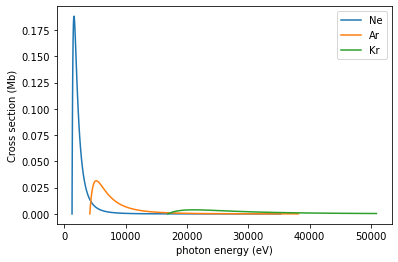

In [ ]:
rf = 20.0

k_vector = np.linspace(0,50,100)
IE_Ne_1s = ((9.642**2)/2)#*27.211
IE_Ar_1s = ((17.508**2)/2)#*27.211
IE_Kr_1s = ((35.232**2)/2)#*27.211
print('IP','','Ne:',IE_Ne_1s,'Ar:',IE_Ar_1s,'Kr:',IE_Kr_1s)
Ne_1s_sig = []; Ar_1s_sig = []; Kr_1s_sig = [];
i = np.complex(0,1)
etot_Ne_1s = []; etot_Ar_1s = []; etot_Kr_1s = [];

for k in k_vector:
  ek = (k**2/2)#*27.211
  etot_Ne_1s.append((ek+IE_Ne_1s))
  etot_Ar_1s.append((ek+IE_Ar_1s))
  etot_Kr_1s.append((ek+IE_Kr_1s))  
  sum_Ne = 0; sum_Ar = 0; sum_Kr = 0;
  for l in [0,1]:
      ang = ang_part(l,0,1,0,0,0)*np.sqrt(4*np.pi/3)  
      real_Ne = integrate.quad(rad_Ne_1s, 0, rf,(l,k,True))[0]*ang
      imag_Ne = integrate.quad(rad_Ne_1s, 0, rf,(l,k,False))[0]#*ang
      sum_Ne += np.complex(real_Ne,imag_Ne)
      real_Ar = integrate.quad(rad_Ar_1s, 0, rf,(l,k,True))[0]*ang
      imag_Ar = integrate.quad(rad_Ar_1s, 0, rf,(l,k,False))[0]#*ang
      sum_Ar += np.complex(real_Ar,imag_Ar)
      real_Kr = integrate.quad(rad_Kr_1s, 0, rf,(l,k,True))[0]*ang
      imag_Kr = integrate.quad(rad_Kr_1s, 0, rf,(l,k,False))[0]#*ang
      sum_Kr += np.complex(real_Kr,imag_Kr)

  d2_Ne = np.abs(sum_Ne)**2
  Ne_1s_sig.append(((4*(np.pi**2)*etot_Ne_1s[-1])*d2_Ne/137)*2)
  d2_Ar = np.abs(sum_Ar)**2
  Ar_1s_sig.append(((4*(np.pi**2)*etot_Ar_1s[-1])*d2_Ar/137)*2)
  d2_Kr = np.abs(sum_Kr)**2
  Kr_1s_sig.append(((4*(np.pi**2)*etot_Kr_1s[-1])*d2_Kr/137)*2) 

#plot 
plt.xlabel('photon energy (eV)')
plt.ylabel('Cross section (Mb)')
etot_Ne_1s_np = np.array(etot_Ne_1s)
Ne_1s_sig_np = np.array(Ne_1s_sig)
etot_Ar_1s_np = np.array(etot_Ar_1s)
Ar_1s_sig_np = np.array(Ar_1s_sig)
etot_Kr_1s_np = np.array(etot_Kr_1s)
Kr_1s_sig_np = np.array(Kr_1s_sig)
plt.plot(etot_Ne_1s_np*27.211,Ne_1s_sig_np*28, label='Ne')#,np.subtract(etot_2s,IE_2s),C2s_sig,'b')
plt.plot(etot_Ar_1s_np*27.211,Ar_1s_sig_np*28, label='Ar')#,np.subtract(etot_2s,IE_2s),C2s_sig,'b')
plt.plot(etot_Kr_1s_np*27.211,Kr_1s_sig_np*28, label='Kr')#,np.subtract(etot_2s,IE_2s),C2s_sig,'b')
plt.legend(loc='upper right')
#plt.xlim(1200,40000)
plt.show()

**12)** Our model predicts binding energies of 1264.4 eV, 4168,8 eV and 16881.6 eV for Neon, Argon and Krypton respectively. The exact values energies are 870,2 eV (Ne), 3205.9 eV (Ar) and 14326 (Kr). This indicates that our model is not reproducing very precisely the binding energies. 

**Why is it so? What would you do to improve the model? What effects are we missing here?**

**13)** The cross section can also be expressed as the ratio of the transition rate between the initial and final states $\Gamma_{FI}$ and the photon flux $J_{EM}$: $\sigma = \frac{\Gamma_{FI}}{J_{EM}}$. The photon flux is given by the number of photons per unit time and unit area. Multiplying the rate by the duration of the pulse, the probability of transition during a given pulse is retrieved. 

To put the cross section into perspective, let's estimate the K-shell X-Ray absorption probability of Ne when exposed to a X-Ray pulse from a third-generation synchrotron radiation source and a X-Ray Free Electron Laser. The maximum value (0.000238Mb) of the calcuated Ne cross section is found at an energy of 1684.2 eV. Let's consider a monocromatized x-ray pulse at a synchrotron (bandwidth 1eV) containing about $10^6$ photons. 

**If such a pulse is focused to a width of 10 $\mu$m, what is the absorption probability per pulse and per atom in the focus? (Ans: $2.38*10^{-10}$). At an XFEL we can have around $10^{10}$ photons per pulse with a focus of 120nm * 120nm. What is the transition probability then? (Ans: $1.653*10^{-2}$).**




### Aditional information

- You may have notice that our present formulation may look a bit too complicated when taking into account the fact that the hydrogen-like wave function for a $1s$ orbital has a rather simple analytical form. This is shown in the lecture notes (section 9.4 and 9.5). Our approach based on the expansion over harmonic spherics for the ejected electron seems a bit too cumbersome. <br> 
However, hydrogen-like wave function are rarelly used when a more accurate description of atoms and molecule is needed. In the later case, the radial part of a molecular orbital is usually expressed as a combination of Gaussian functions or plane-wave, while the angular part can include a mix of functions of different angular momentum, $i.e$ a mix of $s$, $p$, $d$, ... functions. The method described in the present module is used to deal with such situations. 

- Many approximation could have been made to simplify the implementation. For example, the harmonic spherics with $ml=0$ do not have only have a complex part and the $i^l$ factor vanishes because we take the norm. This means that the calculation of some integrals could have been performed only accounting for the real part of the integrant. The goal here was to be as general as possible in order to be able to deal with other kind of situations (different angular momentum and polarization cases as well as different form of the radial part for the molecular orbital $\phi_i$). 